# Задание 1 А/А тест

У нас есть данные АА-теста с 2022-05-17 по 2022-05-23. Нам нужно сделать симуляцию, как будто мы провели 10000(сделаем 100000) АА-тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Нам нужно провести сравнение этих подвыборок t-testом.

# Загружаем библиотеки и подключаемся к базе

In [20]:
import hashlib
import pandahouse
import pandas as pd
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import numpy as np
pd.set_option('display.float_format', '{:.3f}'.format)
import warnings
warnings.filterwarnings('ignore')

In [21]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [22]:
q = """
SELECT *
FROM simulator_20220620.feed_actions 
WHERE toDate(time) >= '2022-05-17' and toDate(time) <= '2022-05-23'
limit 5
"""

Посмотрим на данные:

In [23]:
df = pandahouse.read_clickhouse(q, connection=connection)

print(df.head())

   user_id  post_id action                time  gender  age  country    city  \
0     3011     1283   view 2022-05-17 00:00:00       1   27   Russia  Moscow   
1    11066     1398   like 2022-05-17 00:00:00       0   20   Russia   Tomsk   
2    14843     1454   like 2022-05-17 00:00:00       0   20   Russia  Kaluga   
3    15938     1378   view 2022-05-17 00:00:00       1   19   Russia  Moscow   
4     1725     1507   view 2022-05-17 00:00:01       1   19  Ukraine   Kovel   

        os source  exp_group  
0      iOS    ads          4  
1  Android    ads          3  
2  Android    ads          3  
3  Android    ads          1  
4  Android    ads          4  


# Подготовка и сам A/A тест

Перейдем к нашему CTR:

In [24]:
q = """
SELECT user_id, exp_group, countIf(action='like') likes,
countIf(action='view') views,
countIf(action='like')/countIf(action='view') ctr
from simulator_20220620.feed_actions 
group by user_id, exp_group
having toDate(time)>='2022-06-17' and toDate(time)<='2022-06-23'
"""

И сразу посмотрим на информацию о распредениях в группах:

In [25]:
df_ctr = pandahouse.read_clickhouse(query=q, connection=connection)
df_ctr.groupby('exp_group')['ctr'].describe()[2:4]

,count,mean,std,min,25%,50%,75%,max
exp_group,,,,,,,,
2,14725.000,0.217,0.090,0.000,0.158,0.203,0.264,0.750
3,14885.000,0.214,0.091,0.000,0.156,0.200,0.261,0.750


Параметры распределений групп 2 и 3 достаточно близкие. Посмотрим на их гистограммы

In [26]:
sns.set(rc={'figure.figsize':(15,7)})

Text(0.5, 1.0, 'Распределение CTR')

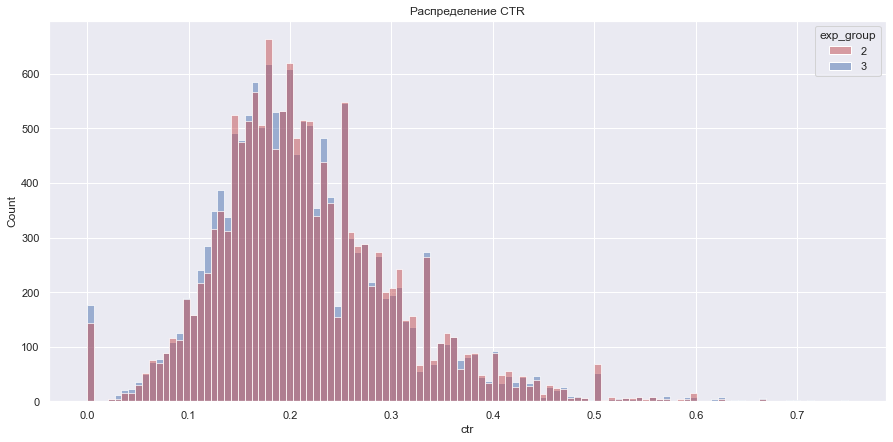

In [27]:
sns.histplot(data = df_ctr[(df_ctr['exp_group']==2) | (df_ctr['exp_group']==3)], 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.title('Распределение CTR')

Все примерно похоже, посчитаем количество ctr = 0 или 1

In [28]:
df_ctr_2 = df_ctr[df_ctr['exp_group']==2]
df_ctr_3 = df_ctr[df_ctr['exp_group']==3]
(df_ctr_2.ctr==0).sum(), (df_ctr_2.ctr==1).sum(), (df_ctr_3.ctr==0).sum(), (df_ctr_3.ctr==1).sum()

(143, 0, 176, 0)

В принципе такой результат и виден на графике, всплеск у нуля. Теперь проведём симуляцию 10000 АА-тестов с подвыборками по 500 пользователей с возвращением из каждой группы. Значения p-value t-тестов сохраним в `result`. Сделаем итерации выборок из множеств групп 2 и 3 и считаем p-value на каждую выборку.

In [29]:
iter = 10**5#сделаем на порядок побольше чем указано в задании,
#чтобы увидеть всплеск p-value у нуля, на 10000 тестах видно(но шумно получается)
sample_size = 500

result=[]
for i in range(0, iter):
    _, pvalue = stats.ttest_ind(df_ctr_2['ctr'].sample(sample_size, replace=True),
                                df_ctr_3['ctr'].sample(sample_size, replace=True),
                                equal_var=False)
    result.append(pvalue)

Посмоторим на распределение p-value

Text(0.5, 1.0, 'Распределение p-values')

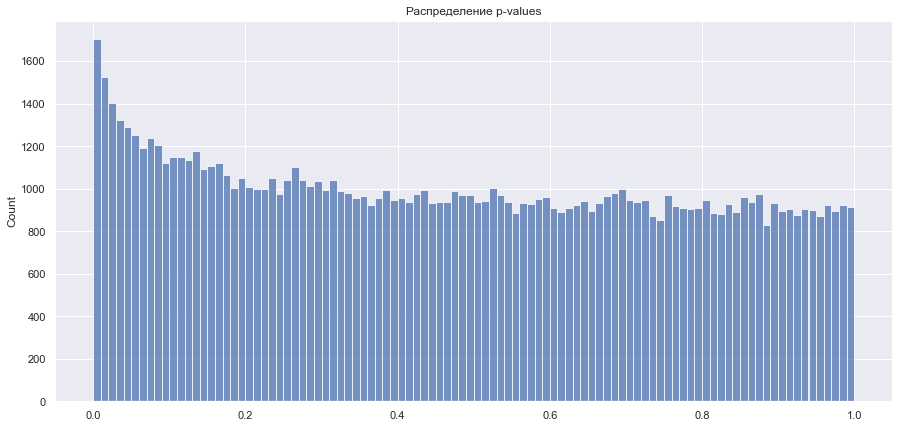

In [30]:
sns.histplot(result, bins=100)
plt.title('Распределение p-values')

Теперь посчитаем долю p-values, которые меньше или равны 0.5.

In [31]:
(pd.Series(result)<=0.05).sum()/(pd.Series(result)).count()

0.07247

Таких p-value оказалось 7%

## Первый вывод  
Доля p-values, равных или меньше 0,5, составляет чуть больше 7%. Само распределение p-values равномерное. Но есть некоторый выступ в районе нуля. 

Из этого можно сделать вывод, что выборки довольно одинаковые. Система сплитования в целом работает.

# Сглаживание

Попробуем применить сглаживание

In [32]:
def smoothed_ctr(like, view, general_ctr, alpha):#сама функция
    return (like + alpha*general_ctr) / (view + alpha)

Считаем глобальные ctr

In [33]:
global_ctr2 = df_ctr_2.likes.sum() / df_ctr_2.views.sum()
global_ctr3 = df_ctr_3.likes.sum() / df_ctr_3.views.sum()

И теперь смотрим на сглаженные ctr

In [34]:
df_ctr_2['smoothed_ctr'] = df_ctr_2.apply(
    lambda x: smoothed_ctr(x['likes'], x['views'], global_ctr2, 5), axis=1)

df_ctr_3['smoothed_ctr'] = df_ctr_3.apply(
    lambda x: smoothed_ctr(x['likes'], x['views'], global_ctr3, 5), axis=1)

Text(0.5, 1.0, 'Сглаженные ctr')

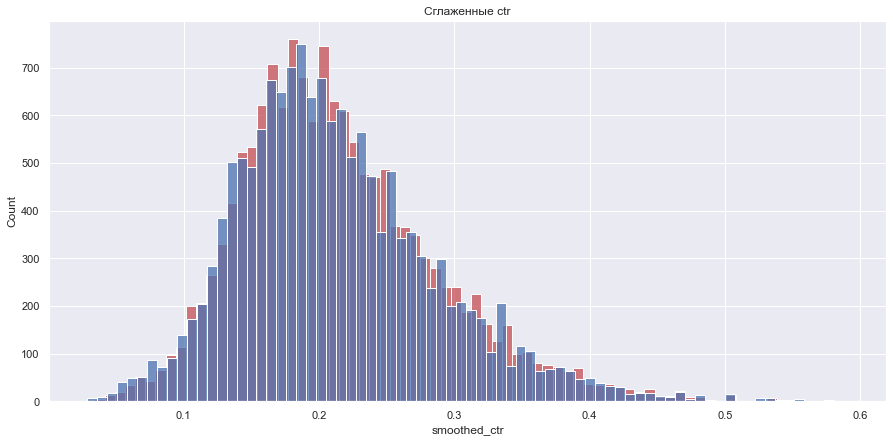

In [35]:
sns.histplot(df_ctr_2.smoothed_ctr, color='r')
sns.histplot(df_ctr_3.smoothed_ctr, color='b')
plt.title('Сглаженные ctr')

Теперь опять делаем итерации выборок из множеств групп 2 и 3 и считаем p-value на каждую выборку.

In [36]:
iter = 10**5 # опять остановимся на 100000
sample_size = 500

result=[]
for i in range(0, iter):
    _, pvalue = stats.ttest_ind(df_ctr_2.smoothed_ctr.sample(sample_size, replace=True),
                                df_ctr_3.smoothed_ctr.sample(sample_size, replace=True),
                                equal_var=False)
    result.append(pvalue)

И смотрим на распределение p-value со сглаживанием

Text(0.5, 1.0, 'Распределение p-values со сглаживанием')

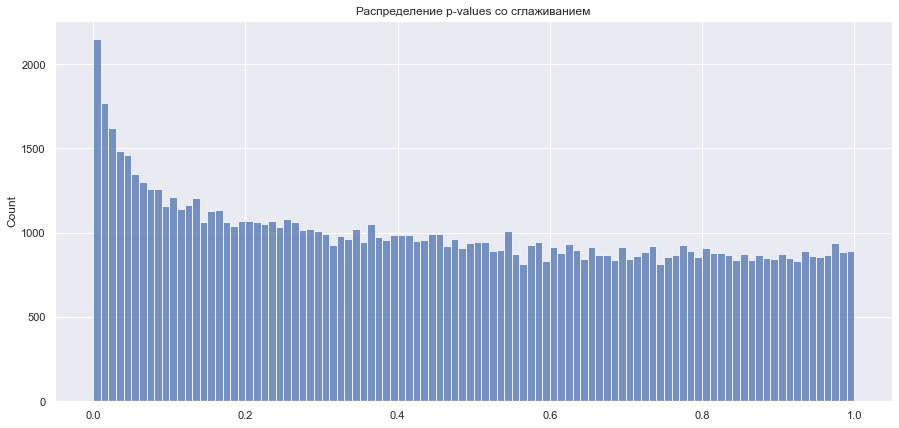

In [37]:
sns.histplot(result, bins=100)
plt.title('Распределение p-values со сглаживанием')

Распредеоение кажется стало немного более равномерным (но всплекск у нуля стал более выраженным). Посчитаем долю p-values, которые меньше или равны 0.5

In [38]:
print(f'Доля p-values меньше или равно 0,05 = {(pd.Series(result)<=0.05).sum()/(pd.Series(result)).count()}')

Доля p-values меньше или равно 0,05 = 0.0848


## Второй вывод
После сглаживания доля p-values, которые меньше или равны 0.5 уведичилась, сглаживание не помогло улучшить результат. Остановимся на версии без сглаживания.